Código disponível [na minha página do Github](https://github.com/arthurkenzo/atividades_ia525)

In [ ]:
import cvxpy as cp
import numpy as np
import mosek
import matplotlib.pyplot as plt


Uma alternativa para definir se um dado ponto $ u $ está dentro do politopo definido pelo conjunto de vértices $ {v_i, i=1,\dots,N} $ é testando se $u$ pode ser escrito como combinação convexa de ${v_i}$. Isso nos levaria a resolver, para cada amostra do método de Monte Carlo, um problema de factibilidade de $N$ variáveis ${\lambda_i}$, tal que

$$ \text{encontrar } \lambda_i: \hspace{10pt} u = \sum_{i=0}^N \lambda_i v_i \hspace{10pt} \text{sujeito a:} \hspace{10pt} \lambda_i \geq 0 \hspace{3pt} \forall i, \hspace{10pt} \sum_{i=0}^N \lambda_i = 1 $$

A princípio, isso me parece custoso (mas posso estar enganado). Uma outra alternativa seria o algoritmo de ray casting ou ray tracing. Nele, traçamos uma reta em uma direção qualquer entre o ponto e a borda da área contendo o polígono. Podemos então calcular os pontos de interseção entre essa reta e cada uma das arestas do polígono por meio da expressão 

$$ x_{\text{intersect}} = A_x + \frac{(P_y - A_y)(B_x - A_x)}{B_y - A_y} $$

Se o total de interseções for ímpar, o ponto é interior ao polígono, e o contrário se o total for par. Este método tem a vantagem de funcionar para polígonos não convexos, e ao menos a princípio parece menos custoso computaioncalmente do que o método de factibilidade. 

## Questão 2:

### Definindo funções e parâmetros para rodar o algoritmo de Monte Carlo

In [25]:
def RayCastingMonteCarlo(vertices:np.ndarray, nbSamples:int):

    counts = 0
    samples = np.zeros((nbSamples, 2))

    for i in range(nbSamples):
        
        # generating samples
        sample = np.random.rand(2) 
        samples[i] = sample
        n = len(vertices)

        for j in range(n):

            # defining the edge's vertices
            vertex1 = vertices[j]
            vertex2 = vertices[(j+1) % n]

            # checking if horizontal ray crosses the edge using the formula found previously
            if (vertex1[1] <= sample[1] <= vertex2[1]) or (vertex2[1] <= sample[1] <= vertex1[1]):
                xIntersect = vertex1[0] + (sample[1] - vertex1[1]) * (vertex2[0] - vertex1[0]) / (vertex2[1] - vertex1[1])
                if sample[0] < xIntersect:
                    counts += 1


    return counts/nbSamples, samples


def SatisfiabilityMonteCarlo(vertices:np.ndarray, nbSamples:int):

    counts = 0
    samples = np.zeros((nbSamples, 2))

    for i in range(nbSamples):

        # generating samples
        sample = np.random.rand(2)
        samples[i] = sample
        
        # building satisfiability problem and solving it
        n = len(vertices)
        vars = cp.Variable(n, name='lambda')

        constraints = [vars >= 0]
        constraints += [cp.sum(vars) == 1]
        constraints += [vertices.T @ vars == sample]

        objective = cp.Minimize(1)
        satProblem = cp.Problem(objective, constraints)
        satProblem.solve(solver="MOSEK", verbose=False)

        # checking if sample is a convex sum of vertices
        if satProblem.status == cp.OPTIMAL:
            counts += 1

    return counts/nbSamples, samples


# defining some simple shapes for testing
verticesSimpleTriangle = np.array([[0, 0], [0, 1], [1, 0]])
verticesSimpleRectangle = np.array([[0, 0], [0, 0.2], [1, 0.2], [1, 0]])

# defining polygon for question 3
q3Polygon = np.array([
    [0.0623, 0.9478],
    [0.9279, 0.9185],
    [0.6410, 0.1372],
    [0.2153, 0.1420],
    [0.0119, 0.4632]
])

### Comparando os resultados para 3 amostragens diferentes

In [26]:
nbSamplesList = [100, 1000, 10000]

print("Estimated area for simple triangle in function of sample number: ")
for nbSamples in nbSamplesList:
    area, samples = RayCastingMonteCarlo(vertices=verticesSimpleTriangle, nbSamples=nbSamples)
    print("samples: {} | area: {}".format(nbSamples, area))
print("expected result: 0.5")

print("")
print("Estimated area for simple rectangle in function of sample number: ")
for nbSamples in nbSamplesList:
    area, samples = RayCastingMonteCarlo(vertices=verticesSimpleRectangle, nbSamples=nbSamples)
    print("samples: {} | area: {}".format(nbSamples, area))
print("expected result: 0.2")

Estimated area for simple triangle in function of sample number: 
samples: 100 | area: 0.48
samples: 1000 | area: 0.492
samples: 10000 | area: 0.5059
expected result: 0.5

Estimated area for simple rectangle in function of sample number: 
samples: 100 | area: 0.19
samples: 1000 | area: 0.218
samples: 10000 | area: 0.199
expected result: 0.2


Podemos observar que uma amostragem maior não necessariamente implica em uma estimativa melhor todas as vezes, visto que se trata de um processo aleatório. No entanto, ainda podemos concluir que existe uma tendência de melhora nas estimativas em função do número de amostras: rodando esse experimento várias vezes poderíamos ver que o desvio padrão nos valores das estimativas seriam muito maiores no caso de M baixo, em comparação a M grande. 

### Utilizando os dois métodos propostos para estimar a área de um triângulo

In [27]:
nbSamples = 5000

# Compute areas and sample points for both methods
area1, samples1 = RayCastingMonteCarlo(vertices=verticesSimpleTriangle, nbSamples=nbSamples)

In [28]:
area2, samples2 = SatisfiabilityMonteCarlo(vertices=verticesSimpleTriangle, nbSamples=nbSamples)

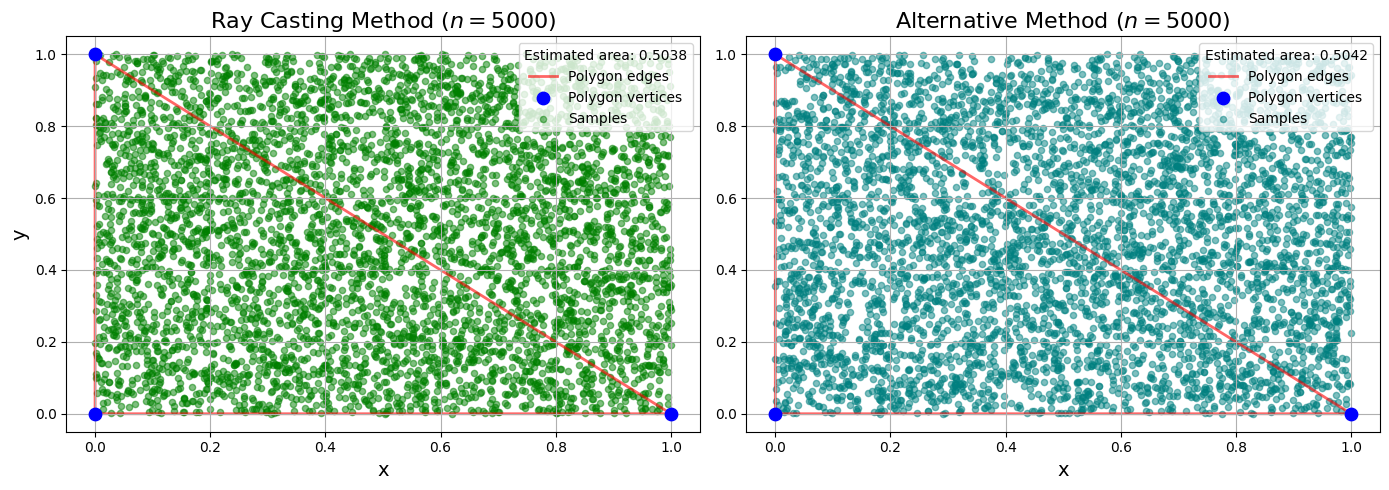

In [29]:
# Separating x and y components
x_poly, y_poly = verticesSimpleTriangle[:, 0], verticesSimpleTriangle[:, 1]
x_samples1, y_samples1 = samples1[:, 0], samples1[:, 1]
x_samples2, y_samples2 = samples2[:, 0], samples2[:, 1]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# First method (Ray Casting)
axes[0].plot(np.append(x_poly, x_poly[0]), np.append(y_poly, y_poly[0]), 'r-', linewidth=2, alpha=0.6, label="Polygon edges", zorder=1)
axes[0].scatter(x_poly, y_poly, color='blue', marker='o', s=80, label="Polygon vertices", zorder=2)
axes[0].scatter(x_samples1, y_samples1, color='green', marker='o', s=20, label="Samples", alpha=0.5, zorder=0)
axes[0].set_title(f"Ray Casting Method ($n={nbSamples}$)", size=16)
axes[0].legend(loc='upper right', title=f'Estimated area: {area1:.4f}')
axes[0].grid(True, zorder=0)
axes[0].set_xlabel("x", size=14)
axes[0].set_ylabel("y", size=14)

# Second method (Alternative Monte Carlo)
axes[1].plot(np.append(x_poly, x_poly[0]), np.append(y_poly, y_poly[0]), 'r-', linewidth=2, alpha=0.6, label="Polygon edges", zorder=1)
axes[1].scatter(x_poly, y_poly, color='blue', marker='o', s=80, label="Polygon vertices", zorder=2)
axes[1].scatter(x_samples2, y_samples2, color='teal', marker='o', s=20, label="Samples", alpha=0.5, zorder=0)
axes[1].set_title(f"Alternative Method ($n={nbSamples}$)", size=16)
axes[1].legend(loc='upper right', title=f'Estimated area: {area2:.4f}')
axes[1].grid(True, zorder=0)
axes[1].set_xlabel("x", size=14)

# Show the figure
plt.tight_layout()
plt.show()

### Utilizando os dois métodos propostos para estimar a área de um retângulo

In [30]:
nbSamples = 5000

# Compute areas and sample points for both methods
area1, samples1 = RayCastingMonteCarlo(vertices=verticesSimpleRectangle, nbSamples=nbSamples)

In [31]:
area2, samples2 = SatisfiabilityMonteCarlo(vertices=verticesSimpleRectangle, nbSamples=nbSamples)

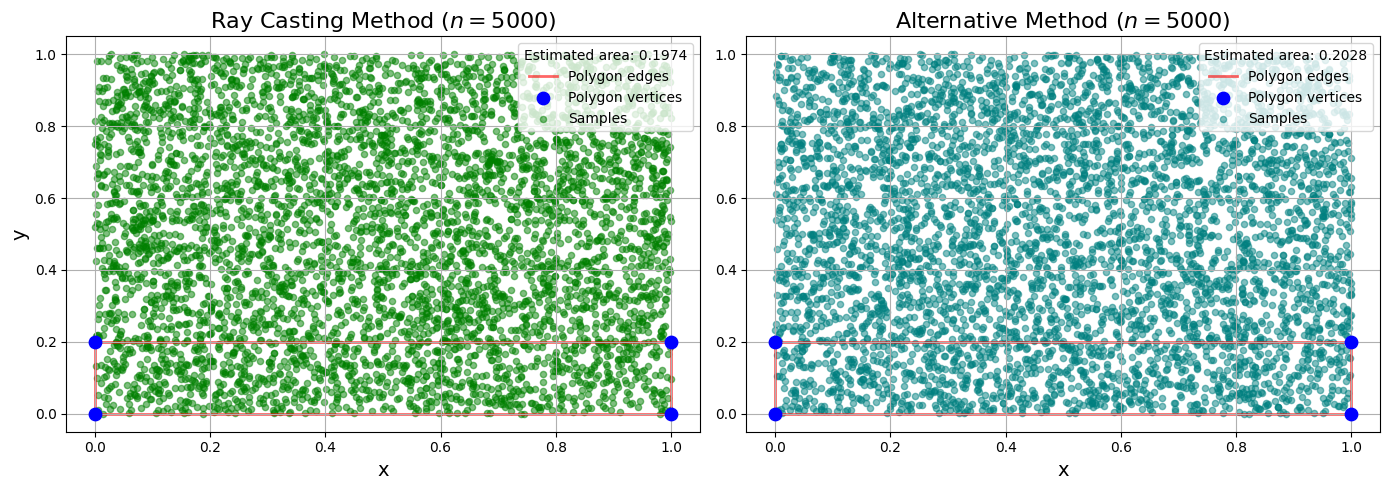

In [32]:
# Separating x and y components
x_poly, y_poly = verticesSimpleRectangle[:, 0], verticesSimpleRectangle[:, 1]
x_samples1, y_samples1 = samples1[:, 0], samples1[:, 1]
x_samples2, y_samples2 = samples2[:, 0], samples2[:, 1]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# First method (Ray Casting)
axes[0].plot(np.append(x_poly, x_poly[0]), np.append(y_poly, y_poly[0]), 'r-', linewidth=2, alpha=0.6, label="Polygon edges", zorder=1)
axes[0].scatter(x_poly, y_poly, color='blue', marker='o', s=80, label="Polygon vertices", zorder=2)
axes[0].scatter(x_samples1, y_samples1, color='green', marker='o', s=20, label="Samples", alpha=0.5, zorder=0)
axes[0].set_title(f"Ray Casting Method ($n={nbSamples}$)", size=16)
axes[0].legend(loc='upper right', title=f'Estimated area: {area1:.4f}')
axes[0].grid(True, zorder=0)
axes[0].set_xlabel("x", size=14)
axes[0].set_ylabel("y", size=14)

# Second method (Alternative Monte Carlo)
axes[1].plot(np.append(x_poly, x_poly[0]), np.append(y_poly, y_poly[0]), 'r-', linewidth=2, alpha=0.6, label="Polygon edges", zorder=1)
axes[1].scatter(x_poly, y_poly, color='blue', marker='o', s=80, label="Polygon vertices", zorder=2)
axes[1].scatter(x_samples2, y_samples2, color='teal', marker='o', s=20, label="Samples", alpha=0.5, zorder=0)
axes[1].set_title(f"Alternative Method ($n={nbSamples}$)", size=16)
axes[1].legend(loc='upper right', title=f'Estimated area: {area2:.4f}')
axes[1].grid(True, zorder=0)
axes[1].set_xlabel("x", size=14)

# Show the figure
plt.tight_layout()
plt.show()

Observamos sobretudo que o método de factibilidade, apesar de válido, é consideravelmente mais lento que o método de ray casting, levando vários segundos para ser executado contra menos de um segundo para o segundo método.

## Questão 3:

### Utilizando os dois métodos propostos para estimar a área do polígono do Moodle

In [33]:
nbSamples = 5000

# Compute areas and sample points for both methods
area1, samples1 = RayCastingMonteCarlo(vertices=q3Polygon, nbSamples=nbSamples)

In [34]:
area2, samples2 = SatisfiabilityMonteCarlo(vertices=q3Polygon, nbSamples=nbSamples)

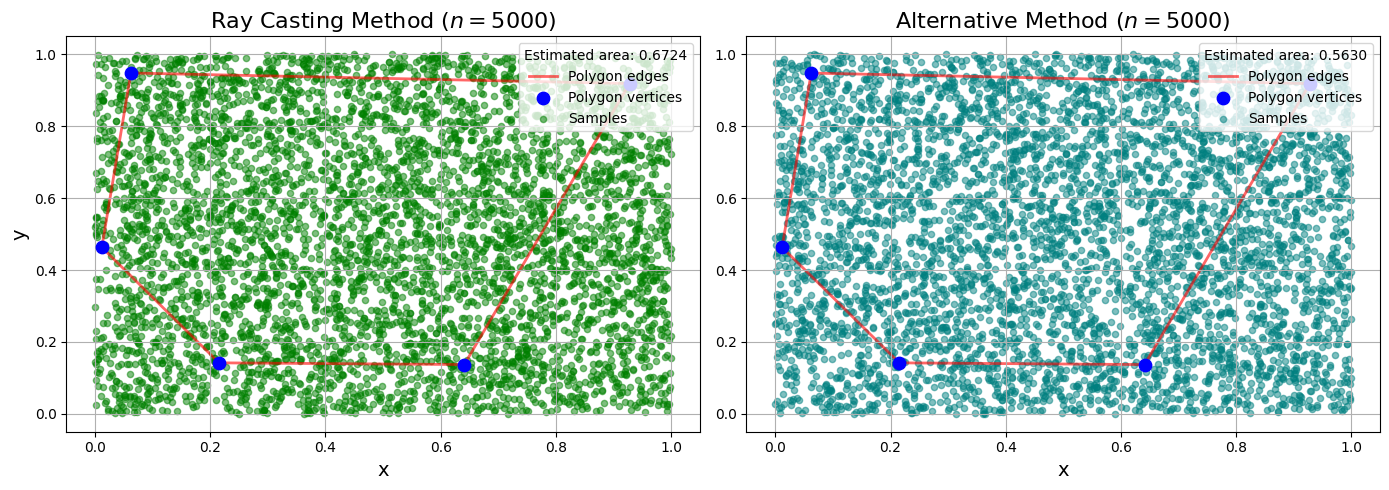

In [35]:
# Separating x and y components
x_poly, y_poly = q3Polygon[:, 0], q3Polygon[:, 1]
x_samples1, y_samples1 = samples1[:, 0], samples1[:, 1]
x_samples2, y_samples2 = samples2[:, 0], samples2[:, 1]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# First method (Ray Casting)
axes[0].plot(np.append(x_poly, x_poly[0]), np.append(y_poly, y_poly[0]), 'r-', linewidth=2, alpha=0.6, label="Polygon edges", zorder=1)
axes[0].scatter(x_poly, y_poly, color='blue', marker='o', s=80, label="Polygon vertices", zorder=2)
axes[0].scatter(x_samples1, y_samples1, color='green', marker='o', s=20, label="Samples", alpha=0.5, zorder=0)
axes[0].set_title(f"Ray Casting Method ($n={nbSamples}$)", size=16)
axes[0].legend(loc='upper right', title=f'Estimated area: {area1:.4f}')
axes[0].grid(True, zorder=0)
axes[0].set_xlabel("x", size=14)
axes[0].set_ylabel("y", size=14)

# Second method (Alternative Monte Carlo)
axes[1].plot(np.append(x_poly, x_poly[0]), np.append(y_poly, y_poly[0]), 'r-', linewidth=2, alpha=0.6, label="Polygon edges", zorder=1)
axes[1].scatter(x_poly, y_poly, color='blue', marker='o', s=80, label="Polygon vertices", zorder=2)
axes[1].scatter(x_samples2, y_samples2, color='teal', marker='o', s=20, label="Samples", alpha=0.5, zorder=0)
axes[1].set_title(f"Alternative Method ($n={nbSamples}$)", size=16)
axes[1].legend(loc='upper right', title=f'Estimated area: {area2:.4f}')
axes[1].grid(True, zorder=0)
axes[1].set_xlabel("x", size=14)

# Show the figure
plt.tight_layout()
plt.show()

## Questão 4:

Sem o ordenamento dos vértices, não temos informação suficiente para construir um polígono sem ambiguidades. Teríamos um número extremamente elevado de possibilidades de formas geométricas possíveis, muitas delas não convexas ou até disjuntas. Isso, além de dificultar a execução do algoritmo de ray casting, simplesmente não nos permitiria chegar no objetivo proposto (estimar a área de um polígono específico). 

No entanto, se tivermos a hipótese adicional de que o polígono é necesssariamente convexo, o primeiro método proposto ainda funcionaria, pois não depende de um ordenamento específico dos vértices. Nesse caso, saberíamos que o polígono deve ser a casca convexa do conjunto de vértices dados. 

## Questão 5:

O método das combinações convexas não funcionaria em um polígono não convexo, visto que neste caso um ponto fora do polígono mas dentro de sua casca convexa seria contabilizado como interno. O segundo método de ray casting é mais adequado para polígonos não convexos, visto que em qualquer situação, um número ímpar de interseções com as arestas (desde que sejam devidamente construídas a partir da lista ordenada de vértices) sempre ocorre com pontos interiores, e o contrário para números pares de interseção e pontos exteriores. 